In [16]:
import sys
import os
from pathlib import Path
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import ChainMap
from scipy.integrate import cumtrapz, trapz
import re
import importlib
import seaborn as sns
sns.set()

%matplotlib inline

In [17]:
# local modules
from fastsim import simdrivehot, simdrive, vehicle, cycle
from fastsim import utilities as utils
from fastsim import parameters as params
import hot_utilities as hot_utils
importlib.reload(hot_utils)
# importlib.reload(simdrive)
# importlib.reload(cycle)

<module 'hot_utilities' from 'C:\\Users\\cbaker2\\Documents\\GitHub\\fastsim\\docs\\hot_utilities.py'>

In [18]:
t0 = time.time()
veh = vehicle.Vehicle(veh_file=
                          Path('../vehdb/2017 Toyota Highlander 3.5 L.csv'))
# dyno data does not warrant altitude correction
# source for dyno parameters:
# C:\Users\cbaker2\Documents\TestData\Highlander Conventional\TestSummary\...
# 61810084 Test Data.txt
veh.vehKg = 4750 / 2.205
dragCoef, wheelRrCoef = utils.abc_to_drag_coeffs(veh.vehKg, veh.frontalAreaM2, 
                                                 30.56, 0.3690, 0.0251)
veh.dragCoef, veh.wheelRrCoef = dragCoef, wheelRrCoef
veh_jit = veh.get_numba_veh()

print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 6.985e-02 s


In [19]:
fuel_HV_btu__lb = 18_547 # source: C:\Users\cbaker2\Documents\TestData\Highlander Conventional\TestSummary
fuel_rho_kg__l = 0.74 # not being used currently
fuel_HV_kj__kg = fuel_HV_btu__lb * 1.055 * 2.205 

In [20]:
t0 = time.time()
cyc_df = pd.read_csv(Path(
    'C:/Users/cbaker2/Documents/TestData/Highlander Conventional/' + 
    '10Hz/61810084 Test Data.txt'), sep='\t')
cyc_df['Fuel_Power_Calc[kW]'] = cyc_df['Eng_FuelFlow_Direct2[gps]'] / 1_000 * fuel_HV_kj__kg
cyc_df['Dyno_Spd[mps]'] = cyc_df['Dyno_Spd[mph]'].values / params.mphPerMps
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 2.454e-01 s


In [21]:
t0 = time.time()
cyc = cycle.Cycle(cyc_dict={'cycSecs':cyc_df['Time[s]'].values, 
                            'cycMps':cyc_df['Dyno_Spd[mps]'].values,})
cyc_jit = cyc.get_numba_cyc()
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 2.993e-03 s


In [22]:
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive()
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 5.086e-02 s


Model uses 0.59% less fuel than test.


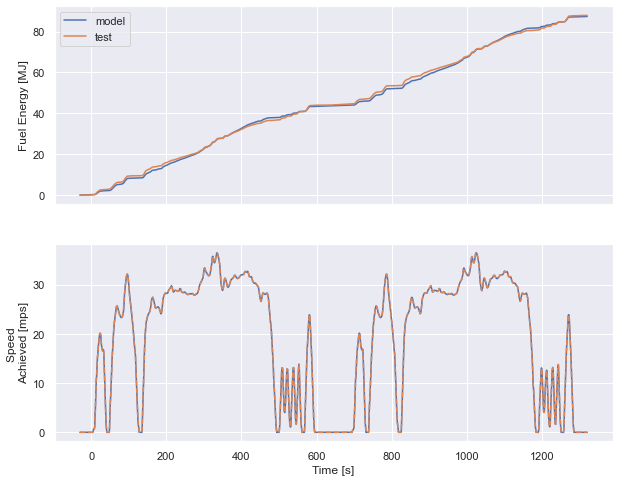

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], cumtrapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch * 1e-3), 
         label='model')
ax1.plot(cyc_df['Time[s]'][1:], cumtrapz(x=cyc_df['Time[s]'], y=cyc_df['Fuel_Power_Calc[kW]'] * 1e-3), 
         label='test')
ax1.set_ylabel('Fuel Energy [MJ]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(cyc_df['Time[s]'], 
         cyc_df['Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=cyc_df['Time[s]'], 
                         y=cyc_df['Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=cyc_df['Time[s]'], 
                         y=cyc_df['Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

In [24]:
# load a list of dfs for cycles
cyc_ids = [('62002026','UDDSx2, CS, -7C, HVAC off'),
          ('61810082','UDDSx2, CS, 25C, HVAC off'),]
#           '618100024':'US06x2, HS, -7C, HVAC off',}
#           '62002042':'-2C Data:  UDDSx2 + US06x1, 72F set',
#           '62003016':'-2C Data:  UDDSx2 + US06x1, 72F set',}

In [25]:
cyc_df_dict = {key:pd.read_csv(
    Path(r'C:\Users\cbaker2\Documents\TestData\Highlander Conventional\10Hz') 
        / Path(key + ' Test Data.txt'))
   for key in [item[0] for item in cyc_ids]}

In [28]:
params = ['fcThrmMass', 'fcDiam', 'hFcToAmbStop', 'radiator_eff',
          'fcTempEffOffset', 'fcTempEffSlope', 'teTStatDeltaDegC', 'teTStatSTODegC']
param_vals = np.array([1.24638517e+02, 1.32330629e+00, 1.01128242e+02, 2.09979938e+01,
       2.90921564e-01, 7.94733767e-03, 6.63340063e+00, 8.83717822e+01])

In [31]:
for cyc_name in tuning_cyc_names:
    test_time_steps = df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values
    test_te_amb = df.loc[idx[cyc_name, :, :], 'Cell_Temp[C]'].values

    cycSecs = np.arange(0, round(test_time_steps[-1], 0))
    cycMps = np.interp(cycSecs, 
        test_time_steps, 
        df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)

    cyc = cycle.Cycle(cyc_dict={'cycSecs':cycSecs, 'cycMps':cycMps})
    cyc_jit = cyc.get_numba_cyc()

    sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit,
                    teAmbDegC=np.interp(cycSecs, test_time_steps, test_te_amb),
                    teFcInitDegC=df.loc[idx[cyc_name, :, 0], 'CylinderHeadTempC'][0]
    )   

    # unpack input parameters
    for i in range(len(x)):
        sim_drive.__setattr__(params[i], x[i])

    sim_drive.teTStatFODegC = sim_drive.teTStatSTODegC + sim_drive.teTStatDeltaDegC
    sim_drive.sim_drive()

    # calculate error
    for i in range(len(error_vars)):
        model_err_var = sim_drive.__getattribute__(error_vars[i][0])
        test_err_var = df.loc[idx[cyc_name, :, :], error_vars[i][1]].values

        err = get_error_val(model_err_var, test_err_var, 
            model_time_steps=cycSecs, test_time_steps=test_time_steps)

        errors.append(err)
    # normalized fuel error
    fuel_err = abs(np.trapz(y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'], x=test_time_steps) - 
                np.trapz(y=sim_drive.fcKwInAch, x=cycSecs)) / \
                    np.trapz(y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'], x=test_time_steps)
    errors.append(fuel_err)

return tuple(errors)


NameError: name 'tuning_cyc_names' is not defined